# Download Transformer
Modules

In [ ]:
!pip install transformers sentencepiece datasets

In [ ]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

/usr/local/lib/python3.10/dist-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
model_repo = 'google/mt5-small'
model_path = '/content/gdrive/My Drive/mt5_translation(bn-en).pt'
max_seq_len = 20

# Load Tokenizer & Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()

# Overview and Quick Test

In [ ]:
token_ids = tokenizer.encode(
    '<jp> This will be translated to Japanese!',
    return_tensors='pt').cuda()
print(token_ids)

model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[ 1042,  3889,   669,  1494,   898,   390, 37194,   285,   288, 30865,
           309,     1]], device='cuda:0')
tensor([[     0, 250099,      1]], device='cuda:0')
<pad> <extra_id_0></s>


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


# Test Tokenizer

In [ ]:
example_input_str = '<jp> This is just a test nbuig.'
# example_input_str = 'これは普通のテスト'
input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

Input IDs: tensor([[1042, 3889,  669, 1494,  339, 1627,  259,  262, 2978,  259,  272, 1982,
         1315,  260,    1]])
Tokens: ['▁<', 'jp', '>', '▁This', '▁is', '▁just', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>']


In [ ]:
sorted(tokenizer.vocab.items(), key=lambda x: x[1])

[('<pad>', 0),
 ('</s>', 1),
 ('<unk>', 2),
 ('<0x00>', 3),
 ('<0x01>', 4),
 ('<0x02>', 5),
 ('<0x03>', 6),
 ('<0x04>', 7),
 ('<0x05>', 8),
 ('<0x06>', 9),
 ('<0x07>', 10),
 ('<0x08>', 11),
 ('<0x09>', 12),
 ('<0x0A>', 13),
 ('<0x0B>', 14),
 ('<0x0C>', 15),
 ('<0x0D>', 16),
 ('<0x0E>', 17),
 ('<0x0F>', 18),
 ('<0x10>', 19),
 ('<0x11>', 20),
 ('<0x12>', 21),
 ('<0x13>', 22),
 ('<0x14>', 23),
 ('<0x15>', 24),
 ('<0x16>', 25),
 ('<0x17>', 26),
 ('<0x18>', 27),
 ('<0x19>', 28),
 ('<0x1A>', 29),
 ('<0x1B>', 30),
 ('<0x1C>', 31),
 ('<0x1D>', 32),
 ('<0x1E>', 33),
 ('<0x1F>', 34),
 ('<0x20>', 35),
 ('<0x21>', 36),
 ('<0x22>', 37),
 ('<0x23>', 38),
 ('<0x24>', 39),
 ('<0x25>', 40),
 ('<0x26>', 41),
 ('<0x27>', 42),
 ('<0x28>', 43),
 ('<0x29>', 44),
 ('<0x2A>', 45),
 ('<0x2B>', 46),
 ('<0x2C>', 47),
 ('<0x2D>', 48),
 ('<0x2E>', 49),
 ('<0x2F>', 50),
 ('<0x30>', 51),
 ('<0x31>', 52),
 ('<0x32>', 53),
 ('<0x33>', 54),
 ('<0x34>', 55),
 ('<0x35>', 56),
 ('<0x36>', 57),
 ('<0x37>', 58),
 ('<0x38>',

# Prepare Dataset

In [ ]:
# Source: https://huggingface.co/datasets/alt
dataset = load_dataset('opus100','bn-en')

In [ ]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [ ]:
train_dataset[0]

{'translation': {'en': 'Other, Private Use', 'hi': 'अन्य, निज़ी उपयोग'}}

In [ ]:
LANG_TOKEN_MAPPING = {

    'bn': '<bn>',
    'en': '<en>',

}

In [ ]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250102, 512)

In [ ]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

tensor([[1042, 3889,  669, 1494,  339, 1627,  259,  262, 2978,  259,  272, 1982,
         1315,  260,    1,    0,    0,    0,    0,    0]])
['▁<', 'jp', '>', '▁This', '▁is', '▁just', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [ ]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)

  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)

    if formatted_data is None:
      continue

    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))

  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [ ]:
# Testing `data_transform`
in_ids, out_ids = format_translation_data(
    train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<hi> ▁Other , ▁Private ▁Use </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁अ न्य , ▁नि ज़ ी ▁उप योग </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

# Training/Finetune google/mt5-small model


In [ ]:
# Constants
n_epochs = 1
batch_size = 16
print_freq = 50
checkpoint_freq = 1000
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
losses = []

In [ ]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [ ]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)

  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      torch.save(model.state_dict(), model_path)

torch.save(model.state_dict(), model_path)

<ipython-input-22-9682a3c86c07>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/33395 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg. loss: 35.510 | lr: 7.507507507507507e-05
Epoch: 1 | Step: 100 | Avg. loss: 19.304 | lr: 0.00015015015015015014
Epoch: 1 | Step: 150 | Avg. loss: 10.204 | lr: 0.00022522522522522523
Epoch: 1 | Step: 200 | Avg. loss: 7.310 | lr: 0.0003003003003003003
Epoch: 1 | Step: 250 | Avg. loss: 4.788 | lr: 0.00037537537537537537
Epoch: 1 | Step: 300 | Avg. loss: 3.445 | lr: 0.00045045045045045046
Epoch: 1 | Step: 350 | Avg. loss: 3.184 | lr: 0.0004997429072651382
Epoch: 1 | Step: 400 | Avg. loss: 3.027 | lr: 0.0004989867521626036
Epoch: 1 | Step: 450 | Avg. loss: 2.697 | lr: 0.0004982305970600689
Epoch: 1 | Step: 500 | Avg. loss: 2.518 | lr: 0.0004974744419575343
Epoch: 1 | Step: 550 | Avg. loss: 2.421 | lr: 0.0004967182868549997
Epoch: 1 | Step: 600 | Avg. loss: 2.277 | lr: 0.000495962131752465
Epoch: 1 | Step: 650 | Avg. loss: 2.320 | lr: 0.0004952059766499305
Epoch: 1 | Step: 700 | Avg. loss: 2.266 | lr: 0.0004944498215473959
Epoch: 1 | Step: 750 | Avg. loss: 2.156 | l

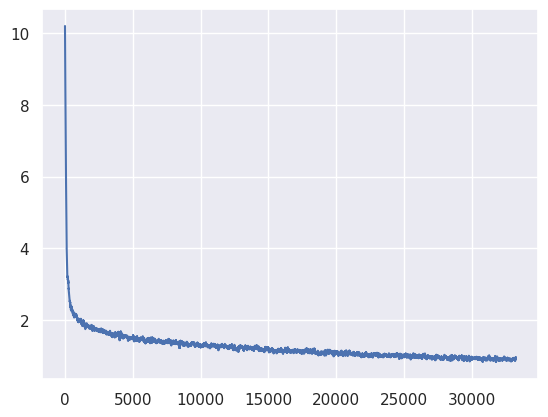

In [ ]:
window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

# Manual Testing

In [ ]:
test_sentence = 'Where do you live?'
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'bn',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: Where do you live?
Truncated input text: <hi> Where do you live?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

तुम कहाँ रहते हो?
आप कहाँ रहते हैं?
तुम कहाँ हो?
